<a href="https://www.kaggle.com/code/jamamo/sex-based-differences-in-dengue-outcomes?scriptVersionId=251481142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import scipy.stats as stats

In [2]:
# Load sex-disaggregated data
df_sex = pd.read_csv('/kaggle/input/sa2-datasets/dengue_cases_deaths_by_sex.csv')
print(df_sex.head())

   Year     Sex  Cases  Deaths
0  2011  Female  58853     370
1  2011    Male  67122     284
2  2012  Female  88243     519
3  2012    Male  98788     402
4  2013  Female  95763     339


In [3]:
df_sex['CFR'] = (df_sex['Deaths'] / df_sex['Cases']) * 100
print(df_sex[['Year', 'Sex', 'CFR']].round(2))

   Year     Sex   CFR
0  2011  Female  0.63
1  2011    Male  0.42
2  2012  Female  0.59
3  2012    Male  0.41
4  2013  Female  0.35
5  2013    Male  0.29
6  2014  Female  0.42
7  2014    Male  0.35
8  2015  Female  0.36
9  2015    Male  0.25


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

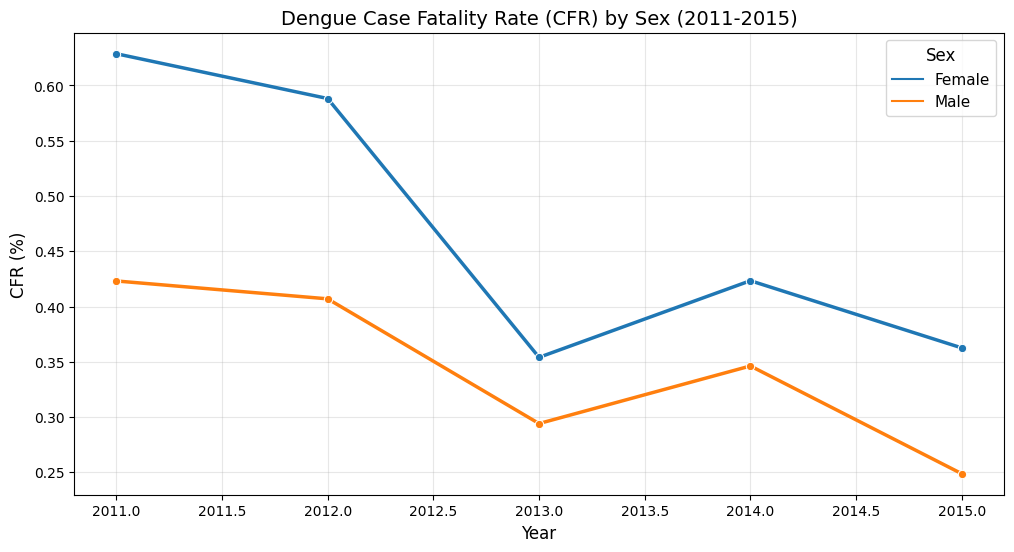

In [4]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sex, x='Year', y='CFR', hue='Sex', marker='o', linewidth=2.5)
plt.title("Dengue Case Fatality Rate (CFR) by Sex (2011-2015)", fontsize=14)
plt.ylabel("CFR (%)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Sex', title_fontsize=12, fontsize=11)
plt.show()

In [5]:
print("\nDescriptive Statistics:")
print(df_sex.groupby('Sex')['CFR'].describe())


Descriptive Statistics:
        count      mean       std       min       25%       50%       75%  \
Sex                                                                         
Female    5.0  0.471341  0.128756  0.353999  0.362545  0.423329  0.588149   
Male      5.0  0.343815  0.073808  0.248723  0.294110  0.346198  0.406932   

             max  
Sex               
Female  0.628685  
Male    0.423110  



Permutation test results:
Observed difference: 0.1275% (Female - Male)
p-value: 0.0434


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


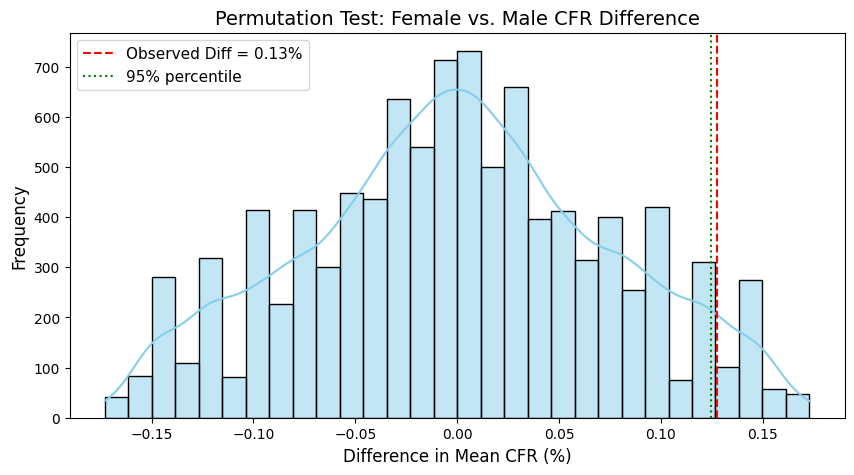

In [6]:
# Observed difference in mean CFR
female_cfr = df_sex[df_sex['Sex'] == 'Female']['CFR']
male_cfr = df_sex[df_sex['Sex'] == 'Male']['CFR']
observed_diff = female_cfr.mean() - male_cfr.mean()

n_permutations = 10_000
combined = np.concatenate([female_cfr, male_cfr])
perm_diffs = np.zeros(n_permutations)

for i in range(n_permutations):
    np.random.shuffle(combined)
    perm_female = combined[:len(female_cfr)]
    perm_male = combined[len(female_cfr):]
    perm_diffs[i] = perm_female.mean() - perm_male.mean()

# Calculate p-value (one-sided)
p_value = (perm_diffs >= observed_diff).mean()
print(f"\nPermutation test results:")
print(f"Observed difference: {observed_diff:.4f}% (Female - Male)")
print(f"p-value: {p_value:.4f}")

# Plot permutation distribution (Enhanced version)
plt.figure(figsize=(10, 5))
sns.histplot(perm_diffs, kde=True, bins=30, color='skyblue')
plt.axvline(observed_diff, color='red', linestyle='--', 
            label=f'Observed Diff = {observed_diff:.2f}%')
plt.axvline(np.percentile(perm_diffs, 95), color='green', linestyle=':', 
            label='95% percentile')
plt.title("Permutation Test: Female vs. Male CFR Difference", fontsize=14)
plt.xlabel("Difference in Mean CFR (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=11)
plt.show()

In [7]:
def bootstrap_ci(data, n_bootstraps=10000, ci=95):
    bootstraps = []
    for _ in range(n_bootstraps):
        sample = resample(data, replace=True)
        bootstraps.append(sample.mean())
    lower = np.percentile(bootstraps, (100 - ci)/2)
    upper = np.percentile(bootstraps, ci + (100 - ci)/2)
    return lower, upper

# Calculate bootstrap CIs
female_ci = bootstrap_ci(female_cfr)
male_ci = bootstrap_ci(male_cfr)
diff_ci = bootstrap_ci(female_cfr - male_cfr.mean())  # CI for the difference

print("\nBootstrap 95% Confidence Intervals:")
print(f"Female CFR: {female_cfr.mean():.2f}% ({female_ci[0]:.2f}% to {female_ci[1]:.2f}%)")
print(f"Male CFR: {male_cfr.mean():.2f}% ({male_ci[0]:.2f}% to {male_ci[1]:.2f}%)")
print(f"Difference (F-M): {observed_diff:.2f}% ({diff_ci[0]:.2f}% to {diff_ci[1]:.2f}%)")


Bootstrap 95% Confidence Intervals:
Female CFR: 0.47% (0.37% to 0.57%)
Male CFR: 0.34% (0.29% to 0.40%)
Difference (F-M): 0.13% (0.03% to 0.23%)


In [8]:
# Fit linear models to assess time trends
years = df_sex['Year'].unique()
female_trend = np.polyfit(years, df_sex[df_sex['Sex'] == 'Female']['CFR'], 1)
male_trend = np.polyfit(years, df_sex[df_sex['Sex'] == 'Male']['CFR'], 1)

print("\nTime Trend Analysis:")
print(f"Female CFR trend: {female_trend[0]:.4f}% per year (slope)")
print(f"Male CFR trend: {male_trend[0]:.4f}% per year (slope)")

# Test if trends are significantly different
def trend_diff_test(female_data, male_data, years, n_permutations=10000):
    combined = np.concatenate([female_data, male_data])
    slopes_diff = np.zeros(n_permutations)
    obs_diff = np.polyfit(years, female_data, 1)[0] - np.polyfit(years, male_data, 1)[0]
    
    for i in range(n_permutations):
        shuffled = np.random.permutation(combined)
        perm_female = shuffled[:len(female_data)]
        perm_male = shuffled[len(female_data):]
        slopes_diff[i] = (np.polyfit(years, perm_female, 1)[0] - 
                          np.polyfit(years, perm_male, 1)[0])
    
    p_value = (np.abs(slopes_diff) >= np.abs(obs_diff)).mean()
    return obs_diff, p_value

trend_diff, trend_p_value = trend_diff_test(
    df_sex[df_sex['Sex'] == 'Female']['CFR'],
    df_sex[df_sex['Sex'] == 'Male']['CFR'],
    years
)

print(f"\nDifference in time trends: {trend_diff:.4f}% per year")
print(f"p-value for trend difference: {trend_p_value:.4f}")


Time Trend Analysis:
Female CFR trend: -0.0697% per year (slope)
Male CFR trend: -0.0410% per year (slope)

Difference in time trends: -0.0288% per year
p-value for trend difference: 0.6171
